# Master Thesis Notebook

## Setup

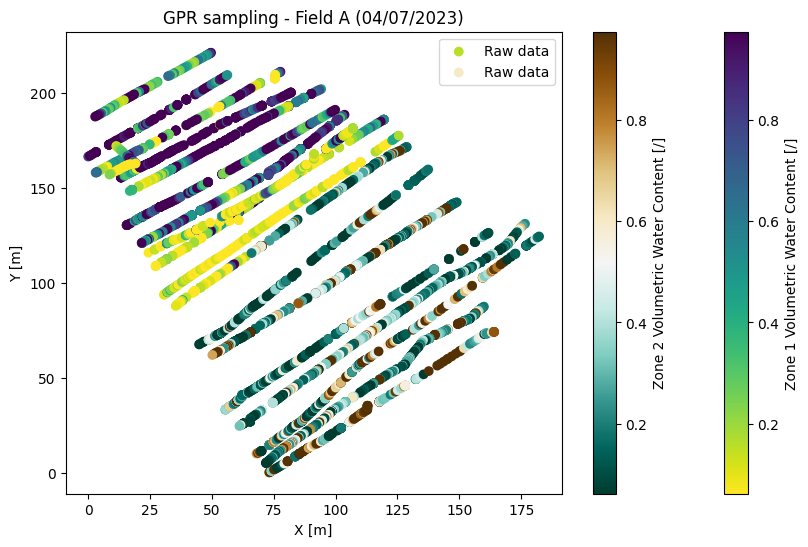

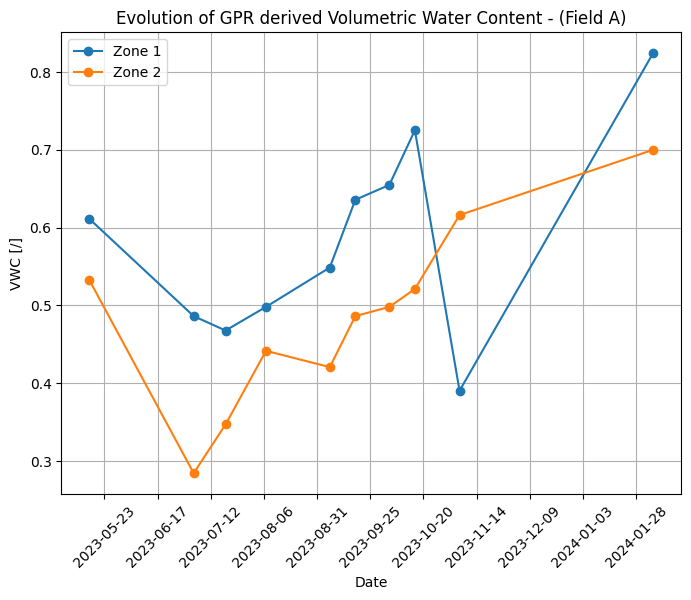

In [2]:
# Importation of the classes and methods associated
from classes import *
GprAnalysis(field_letter="A", sample_number=1).zonal_check()


## GPR VWC Analysis

### Raw data

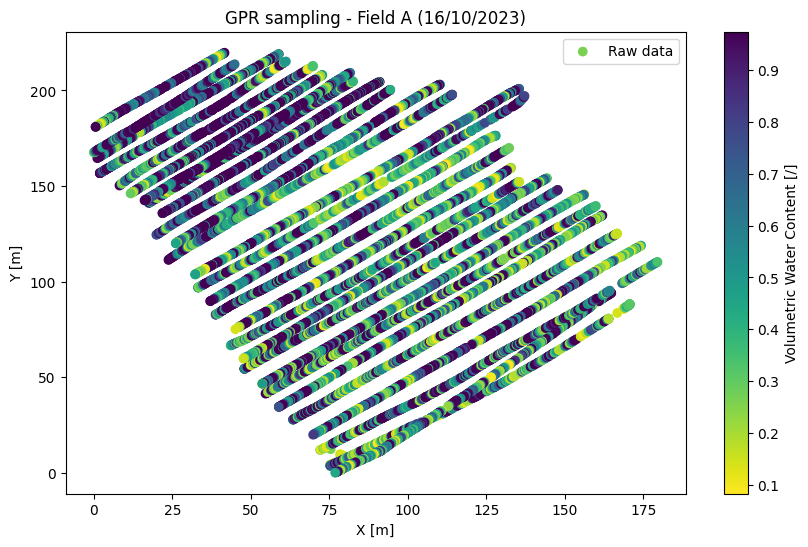

In [2]:
# Instance creation
gpr_a = GprAnalysis(field_letter="A", sample_number=7)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_a.plot_raw_data()

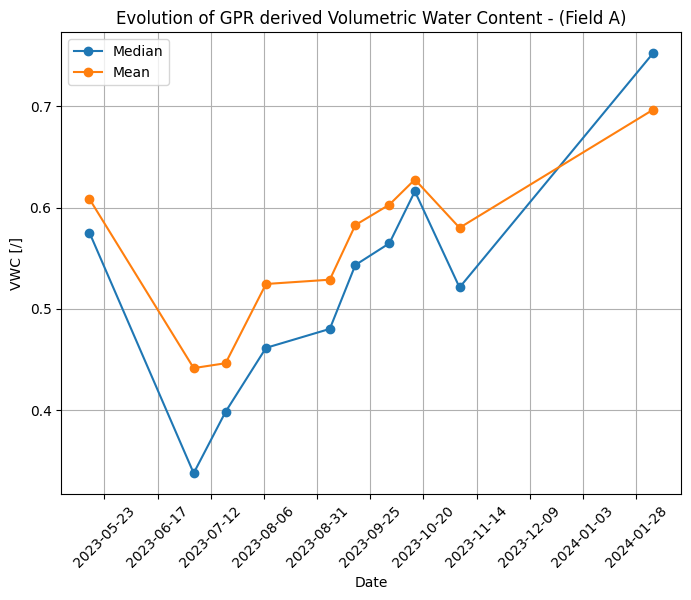

In [3]:
# Mean and median evolution (raw data)
gpr_a.plot_mean_median(plot=True)

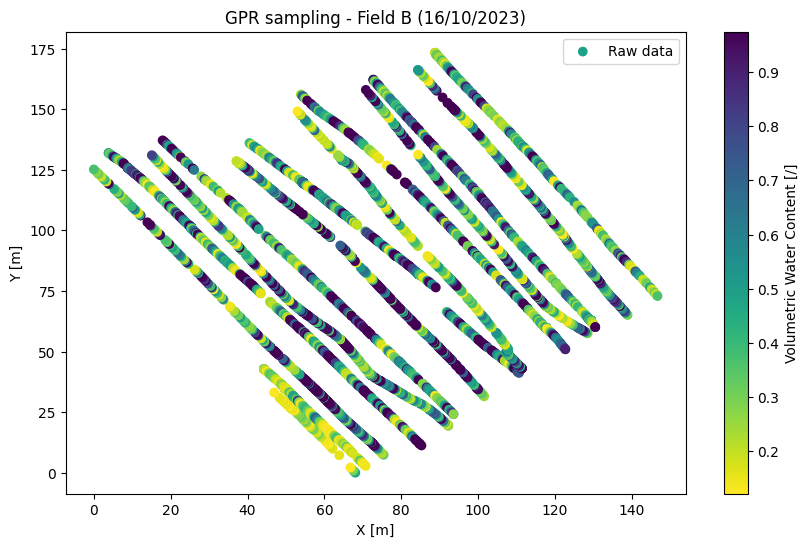

In [4]:
# Instance creation
gpr_b = GprAnalysis(field_letter="B", sample_number=7)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_b.plot_raw_data()

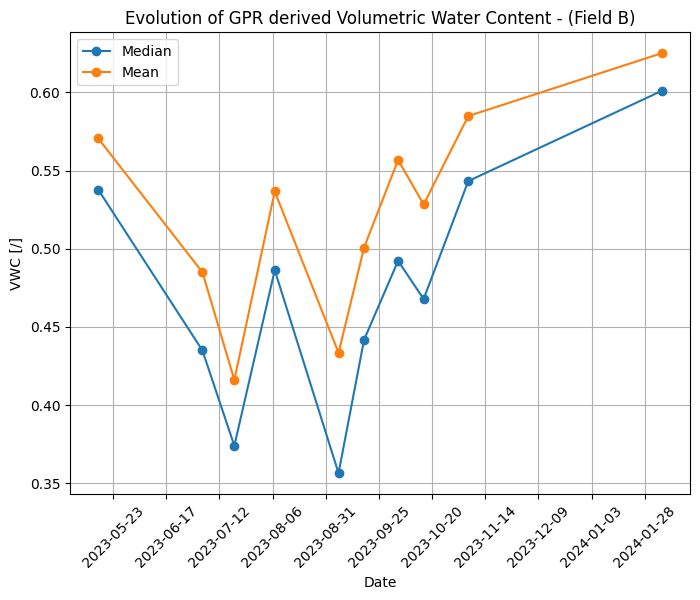

In [5]:
# Median evolution (raw data)
gpr_b.plot_mean_median(plot=True)

### Choosing the variogram model

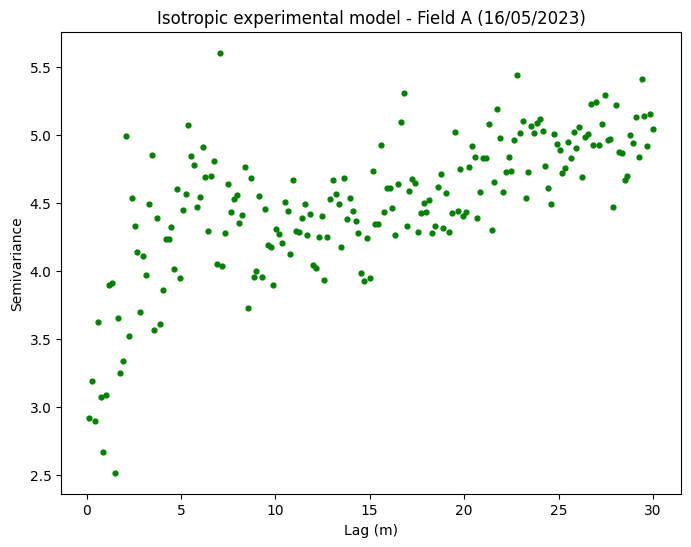

In [6]:
experimental_vario_a = Variogram(resolution=0.00002, field_letter="A", sample_number=0)

experimental_vario_a.determ_experimental_vario() ;
# ; hide output of the cell

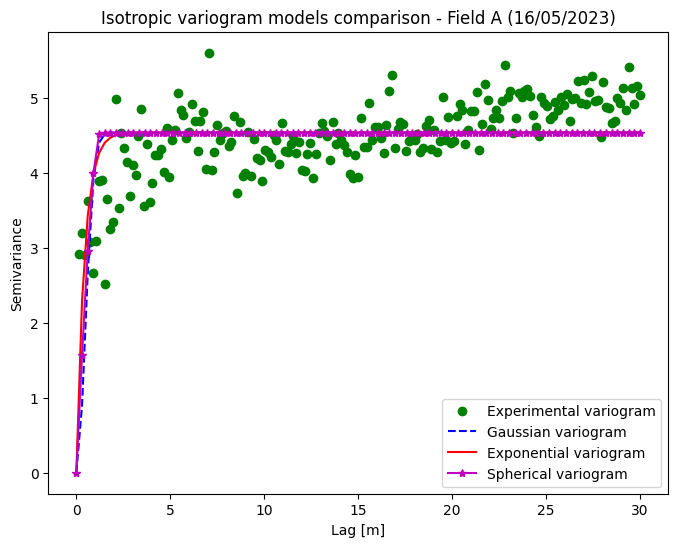

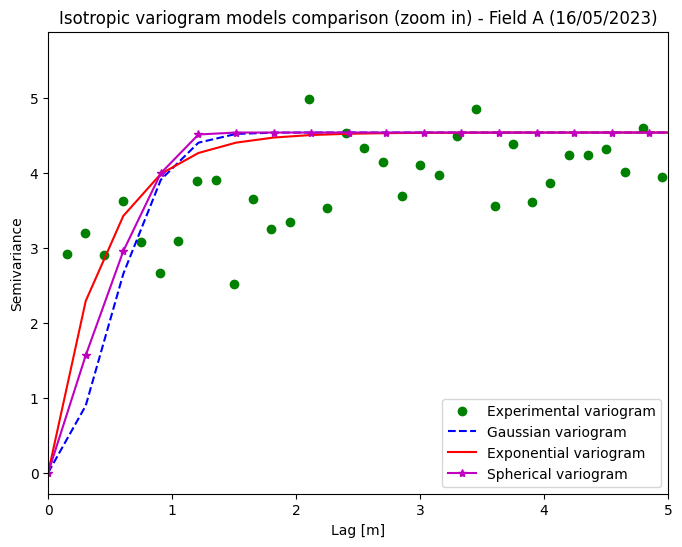

In [7]:
experimental_vario_a.fit_models()

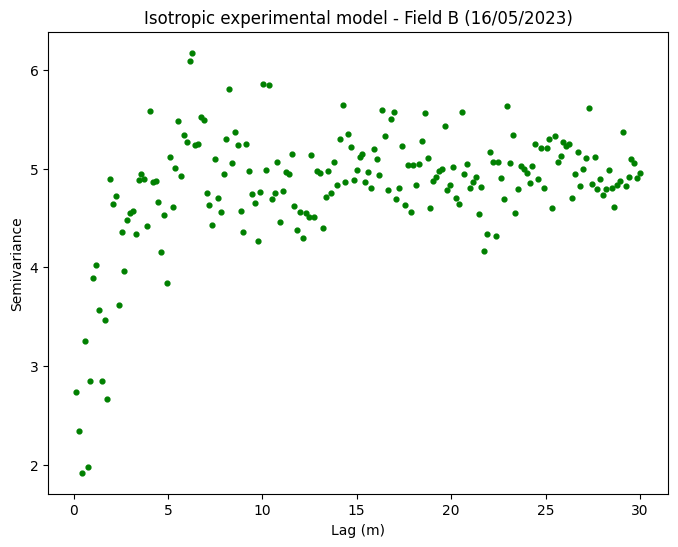

In [8]:
experimental_vario_b = Variogram(resolution=0.00002, field_letter="B", sample_number=0)

experimental_vario_b.determ_experimental_vario() ;

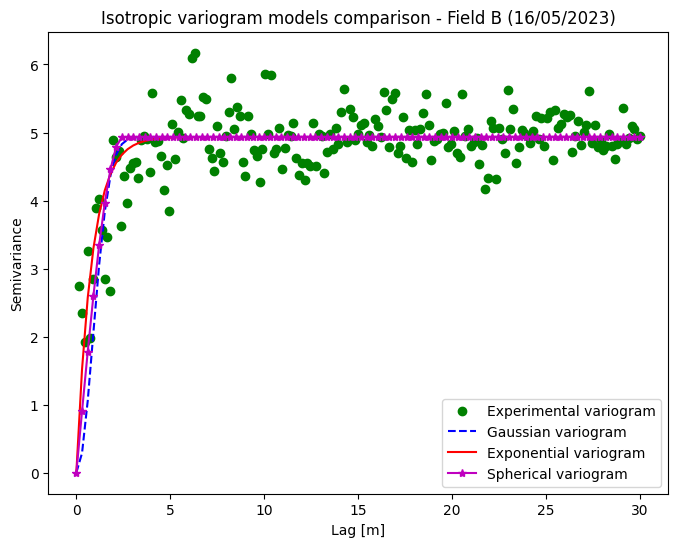

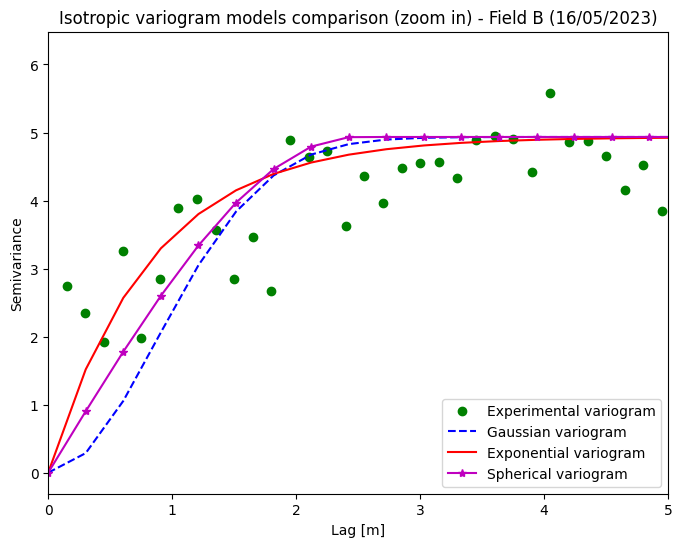

In [9]:
experimental_vario_b.fit_models()

### Kriged data

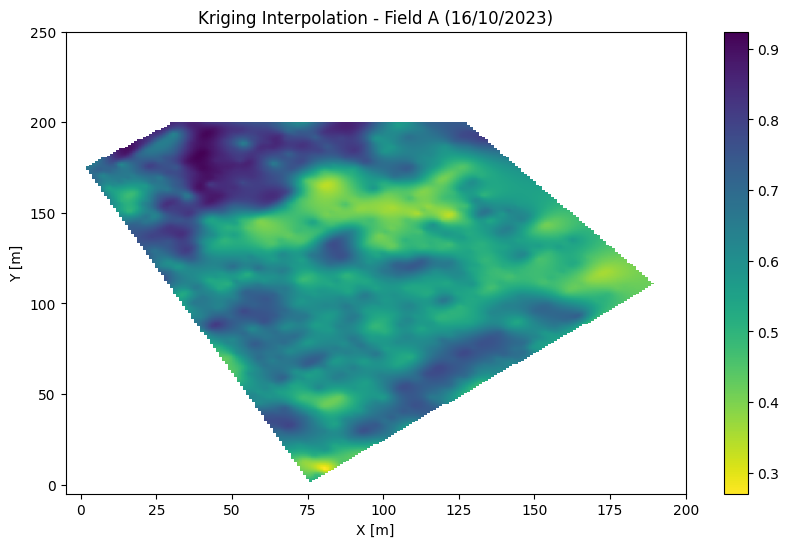

In [10]:
gpr_a.kriging(plot=True)

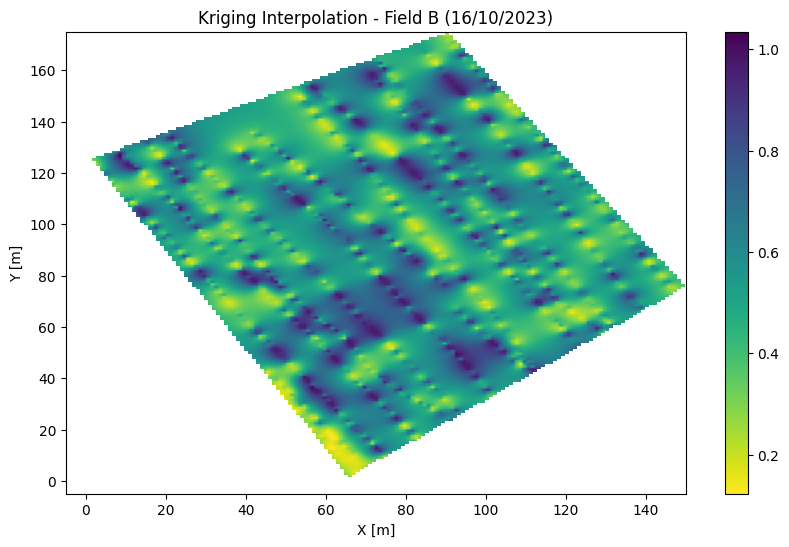

In [11]:
gpr_b.kriging(plot=True)

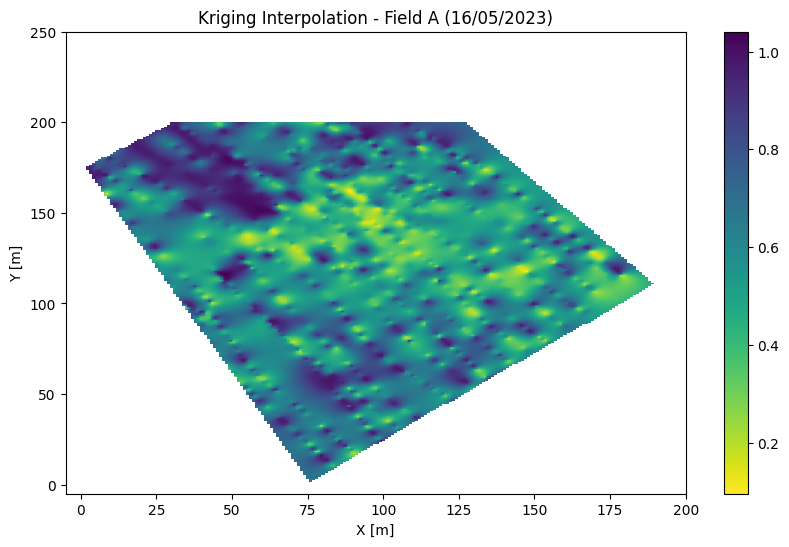

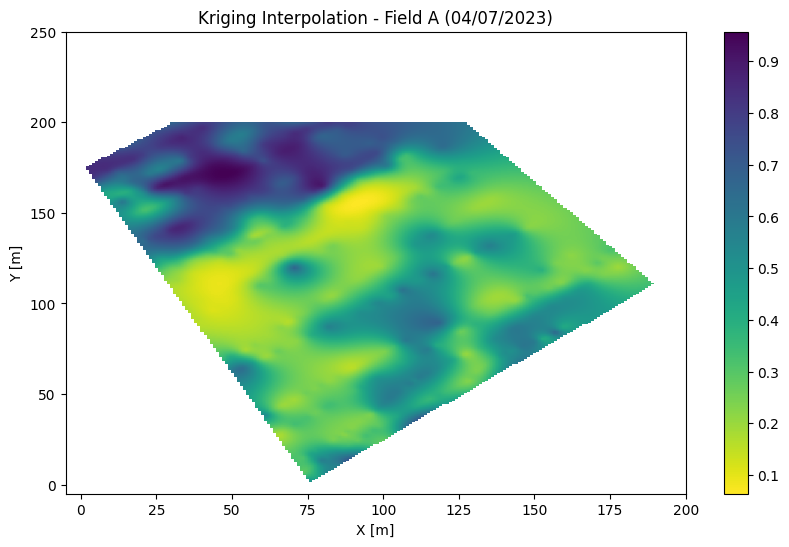

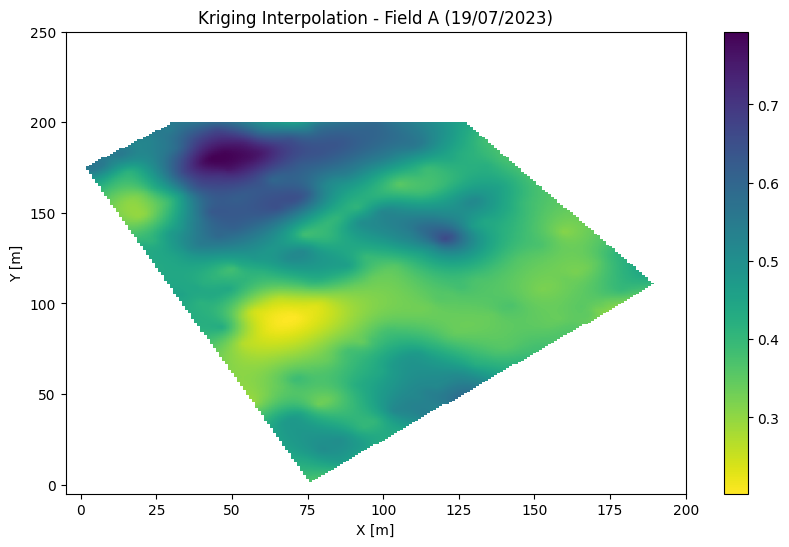

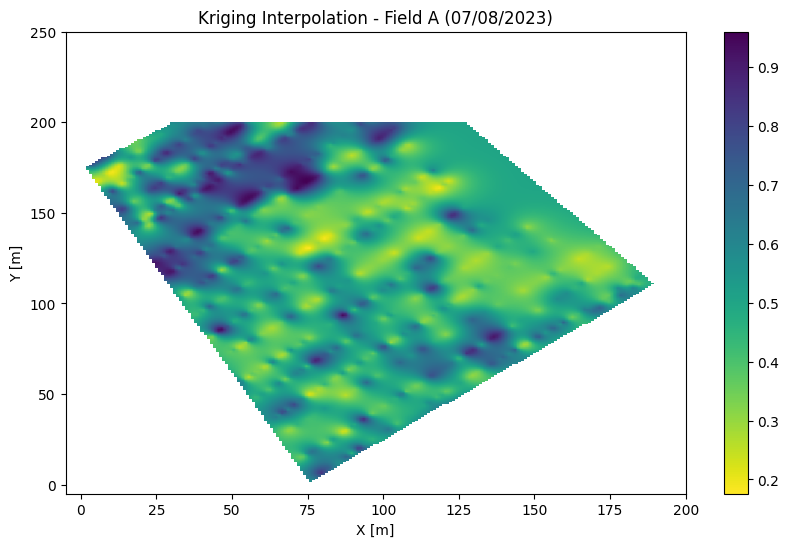

In [12]:
for i in range(10):
    GprAnalysis(field_letter="A", sample_number=i).kriging(plot=True)

In [ ]:
GprAnalysis(field_letter="B", sample_number=0).kriging(plot=True)

6.049824 6.0517883 50.496886 50.498295


IndexError: list index out of range

## TDR Verification

In [ ]:
tdr_verif = TdrAnalysis()
tdr_verif.plot_tdr_evolution()

## Rainfall Analysis

In [ ]:
rf_mr = Rainfall()
rf_mr.plot_data()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


In [ ]:
multi_a = MultispecAnalysis(
    temperature_raster=MultispecAnalysis.TEMPERATURE_RASTER, ndvi_raster=MultispecAnalysis.NDVI_RASTER
)

multi_a.calculate_tvdi()